# 20-2. 조건 없는 생성모델(Unconditional Generative Model), GAN

## 프로젝트 수행
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요. (어떠한 방법을 사용했는지 적어주세요.)


2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.


3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.


4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.


5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [56]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


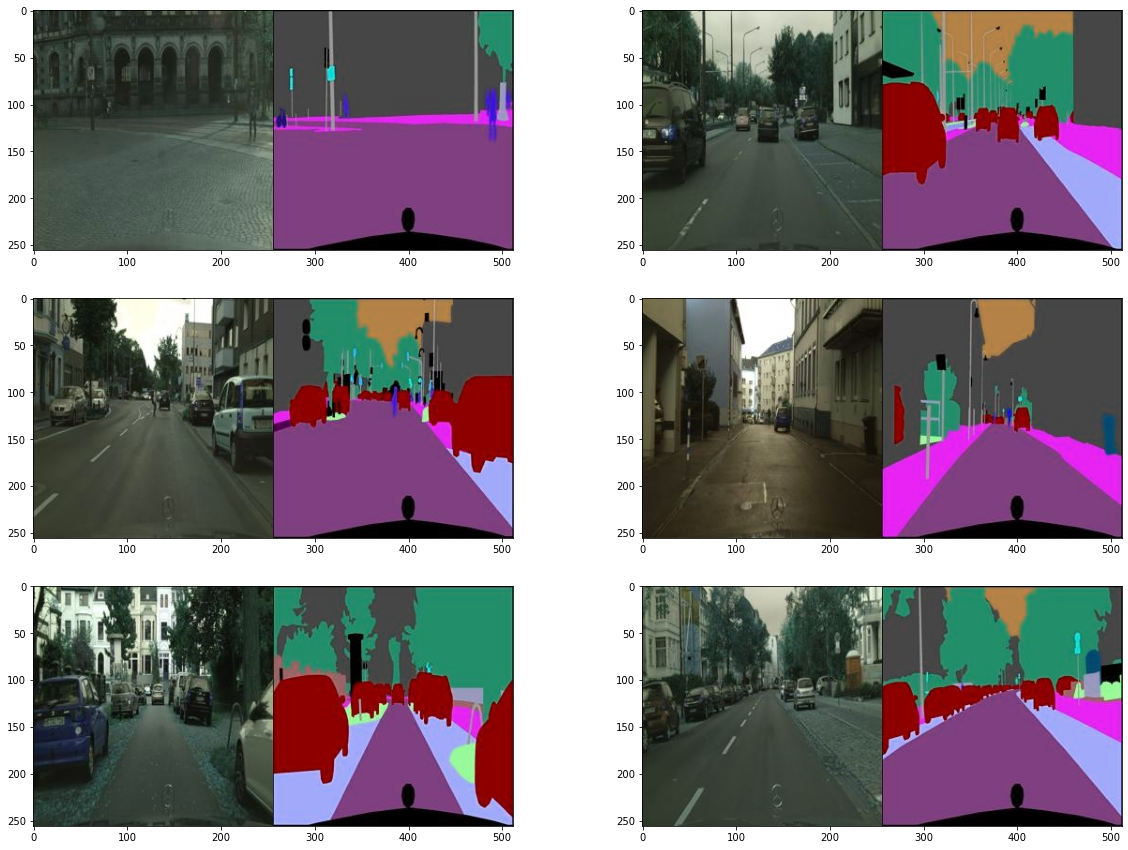

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [58]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


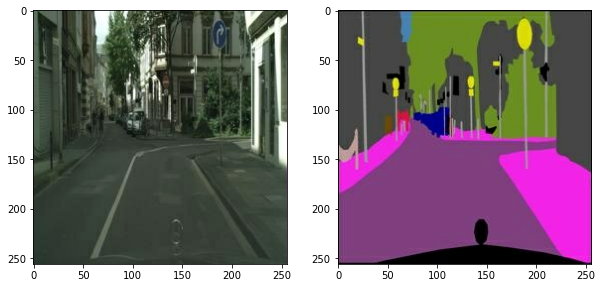

In [59]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [60]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])

    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")


✅


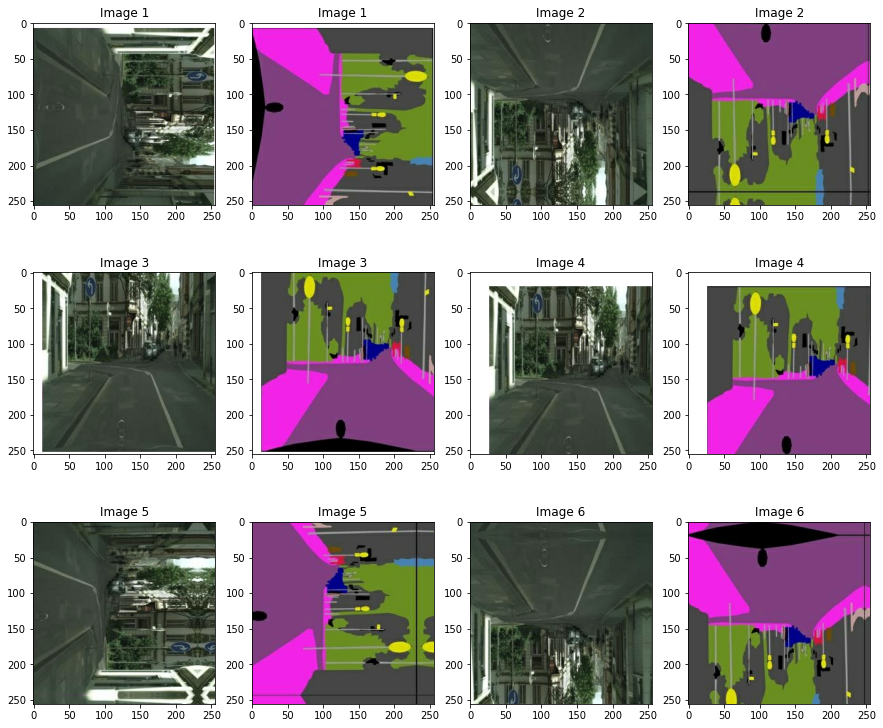

In [61]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

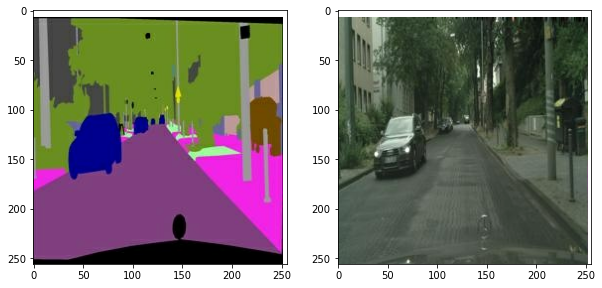

In [62]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [63]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [64]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [65]:
Encoder().get_summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_72 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_73 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_74 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_75 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_76 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_77 (EncodeBlock (None, 4, 4, 512)         419

In [66]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [67]:
Decoder().get_summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_63 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_64 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_65 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_66 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_67 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_68 (DecodeBlock (None, 64, 64, 128)       524

In [68]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [69]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [70]:
UNetGenerator().get_summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_80 (EncodeBlock)   (None, 128, 128, 64) 3072        input_15[0][0]                   
__________________________________________________________________________________________________
encode_block_81 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_80[0][0]            
__________________________________________________________________________________________________
encode_block_82 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_81[0][0]            
___________________________________________________________________________________________

In [71]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [72]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_20 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_194 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_126 (LeakyReLU)  (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [73]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [74]:
Discriminator().get_summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_44 (Concatenate)    (None, 256, 256, 6)  0           input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
disc_block_45 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_44[0][0]      

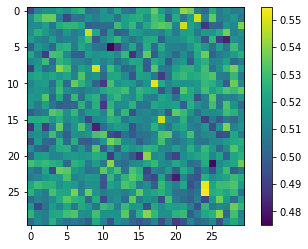

In [75]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [76]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [77]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [78]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [79]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9669                     
L1_loss:0.3615                     
Discriminator_loss:1.3989

EPOCH[1] - STEP[20]                     
Generator_loss:1.0594                     
L1_loss:0.2065                     
Discriminator_loss:1.1511

EPOCH[1] - STEP[30]                     
Generator_loss:1.0187                     
L1_loss:0.1998                     
Discriminator_loss:1.5056

EPOCH[1] - STEP[40]                     
Generator_loss:0.8246                     
L1_loss:0.1896                     
Discriminator_loss:1.2207

EPOCH[1] - STEP[50]                     
Generator_loss:0.8506                     
L1_loss:0.1936                     
Discriminator_loss:1.2885

EPOCH[1] - STEP[60]                     
Generator_loss:0.9382                     
L1_loss:0.1971                     
Discriminator_loss:1.1551

EPOCH[1] - STEP[70]                     
Generator_loss:1.0837                     
L1_loss:0.2086                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.0918                     
L1_loss:0.1773                     
Discriminator_loss:1.3612

EPOCH[3] - STEP[80]                     
Generator_loss:2.1172                     
L1_loss:0.1797                     
Discriminator_loss:0.7655

EPOCH[3] - STEP[90]                     
Generator_loss:2.4527                     
L1_loss:0.1726                     
Discriminator_loss:1.4052

EPOCH[3] - STEP[100]                     
Generator_loss:1.6125                     
L1_loss:0.1882                     
Discriminator_loss:0.6987

EPOCH[3] - STEP[110]                     
Generator_loss:1.1388                     
L1_loss:0.1588                     
Discriminator_loss:2.1531

EPOCH[3] - STEP[120]                     
Generator_loss:1.2402                     
L1_loss:0.2029                     
Discriminator_loss:0.6845

EPOCH[3] - STEP[130]                     
Generator_loss:2.1316                     
L1_loss:0.1846                

EPOCH[5] - STEP[130]                     
Generator_loss:2.6855                     
L1_loss:0.1628                     
Discriminator_loss:0.9655

EPOCH[5] - STEP[140]                     
Generator_loss:1.4613                     
L1_loss:0.1811                     
Discriminator_loss:0.4489

EPOCH[5] - STEP[150]                     
Generator_loss:0.9250                     
L1_loss:0.2281                     
Discriminator_loss:0.7181

EPOCH[5] - STEP[160]                     
Generator_loss:2.0970                     
L1_loss:0.1693                     
Discriminator_loss:0.6013

EPOCH[5] - STEP[170]                     
Generator_loss:1.2473                     
L1_loss:0.1867                     
Discriminator_loss:0.7654

EPOCH[5] - STEP[180]                     
Generator_loss:1.5575                     
L1_loss:0.1941                     
Discriminator_loss:0.3963

EPOCH[5] - STEP[190]                     
Generator_loss:1.8946                     
L1_loss:0.1567             

EPOCH[7] - STEP[190]                     
Generator_loss:0.3916                     
L1_loss:0.1925                     
Discriminator_loss:1.3187

EPOCH[7] - STEP[200]                     
Generator_loss:1.1682                     
L1_loss:0.1776                     
Discriminator_loss:0.8313

EPOCH[7] - STEP[210]                     
Generator_loss:1.0805                     
L1_loss:0.1779                     
Discriminator_loss:0.7067

EPOCH[7] - STEP[220]                     
Generator_loss:0.8280                     
L1_loss:0.1838                     
Discriminator_loss:0.7335

EPOCH[7] - STEP[230]                     
Generator_loss:1.3431                     
L1_loss:0.1745                     
Discriminator_loss:0.8515

EPOCH[7] - STEP[240]                     
Generator_loss:0.2777                     
L1_loss:0.1724                     
Discriminator_loss:1.8655

EPOCH[7] - STEP[250]                     
Generator_loss:1.9077                     
L1_loss:0.1941             

EPOCH[9] - STEP[250]                     
Generator_loss:0.4633                     
L1_loss:0.1708                     
Discriminator_loss:2.5809

EPOCH[10] - STEP[10]                     
Generator_loss:1.3373                     
L1_loss:0.1915                     
Discriminator_loss:0.3734

EPOCH[10] - STEP[20]                     
Generator_loss:1.0602                     
L1_loss:0.1744                     
Discriminator_loss:0.9932

EPOCH[10] - STEP[30]                     
Generator_loss:2.3042                     
L1_loss:0.1652                     
Discriminator_loss:0.7860

EPOCH[10] - STEP[40]                     
Generator_loss:0.8819                     
L1_loss:0.2322                     
Discriminator_loss:0.6723

EPOCH[10] - STEP[50]                     
Generator_loss:0.6241                     
L1_loss:0.1666                     
Discriminator_loss:1.0407

EPOCH[10] - STEP[60]                     
Generator_loss:1.8626                     
L1_loss:0.2131             

EPOCH[12] - STEP[60]                     
Generator_loss:2.2534                     
L1_loss:0.1848                     
Discriminator_loss:0.7903

EPOCH[12] - STEP[70]                     
Generator_loss:2.5818                     
L1_loss:0.1908                     
Discriminator_loss:0.9390

EPOCH[12] - STEP[80]                     
Generator_loss:1.0529                     
L1_loss:0.1719                     
Discriminator_loss:1.3823

EPOCH[12] - STEP[90]                     
Generator_loss:1.4848                     
L1_loss:0.1575                     
Discriminator_loss:0.7726

EPOCH[12] - STEP[100]                     
Generator_loss:2.4429                     
L1_loss:0.1743                     
Discriminator_loss:1.0937

EPOCH[12] - STEP[110]                     
Generator_loss:0.9493                     
L1_loss:0.1744                     
Discriminator_loss:1.0395

EPOCH[12] - STEP[120]                     
Generator_loss:2.2468                     
L1_loss:0.1915          

EPOCH[14] - STEP[120]                     
Generator_loss:1.1697                     
L1_loss:0.1871                     
Discriminator_loss:0.4888

EPOCH[14] - STEP[130]                     
Generator_loss:1.2072                     
L1_loss:0.1867                     
Discriminator_loss:0.5775

EPOCH[14] - STEP[140]                     
Generator_loss:0.9889                     
L1_loss:0.1864                     
Discriminator_loss:1.1256

EPOCH[14] - STEP[150]                     
Generator_loss:2.4522                     
L1_loss:0.1796                     
Discriminator_loss:0.8538

EPOCH[14] - STEP[160]                     
Generator_loss:0.9375                     
L1_loss:0.1832                     
Discriminator_loss:0.7651

EPOCH[14] - STEP[170]                     
Generator_loss:0.2905                     
L1_loss:0.1580                     
Discriminator_loss:1.9793

EPOCH[14] - STEP[180]                     
Generator_loss:2.2424                     
L1_loss:0.1862      

EPOCH[16] - STEP[180]                     
Generator_loss:1.6907                     
L1_loss:0.1904                     
Discriminator_loss:0.3788

EPOCH[16] - STEP[190]                     
Generator_loss:1.5602                     
L1_loss:0.1833                     
Discriminator_loss:0.3286

EPOCH[16] - STEP[200]                     
Generator_loss:0.6371                     
L1_loss:0.1469                     
Discriminator_loss:1.3081

EPOCH[16] - STEP[210]                     
Generator_loss:1.4404                     
L1_loss:0.1948                     
Discriminator_loss:0.3833

EPOCH[16] - STEP[220]                     
Generator_loss:0.9900                     
L1_loss:0.1844                     
Discriminator_loss:0.6435

EPOCH[16] - STEP[230]                     
Generator_loss:2.4568                     
L1_loss:0.1827                     
Discriminator_loss:0.1685

EPOCH[16] - STEP[240]                     
Generator_loss:0.9660                     
L1_loss:0.1651      

EPOCH[18] - STEP[240]                     
Generator_loss:0.6829                     
L1_loss:0.2082                     
Discriminator_loss:0.8954

EPOCH[18] - STEP[250]                     
Generator_loss:2.3186                     
L1_loss:0.1801                     
Discriminator_loss:0.6748

EPOCH[19] - STEP[10]                     
Generator_loss:2.1005                     
L1_loss:0.2091                     
Discriminator_loss:1.0614

EPOCH[19] - STEP[20]                     
Generator_loss:1.5193                     
L1_loss:0.1781                     
Discriminator_loss:0.6851

EPOCH[19] - STEP[30]                     
Generator_loss:1.6144                     
L1_loss:0.1746                     
Discriminator_loss:0.4123

EPOCH[19] - STEP[40]                     
Generator_loss:1.0748                     
L1_loss:0.1944                     
Discriminator_loss:0.7910

EPOCH[19] - STEP[50]                     
Generator_loss:1.9212                     
L1_loss:0.1723           

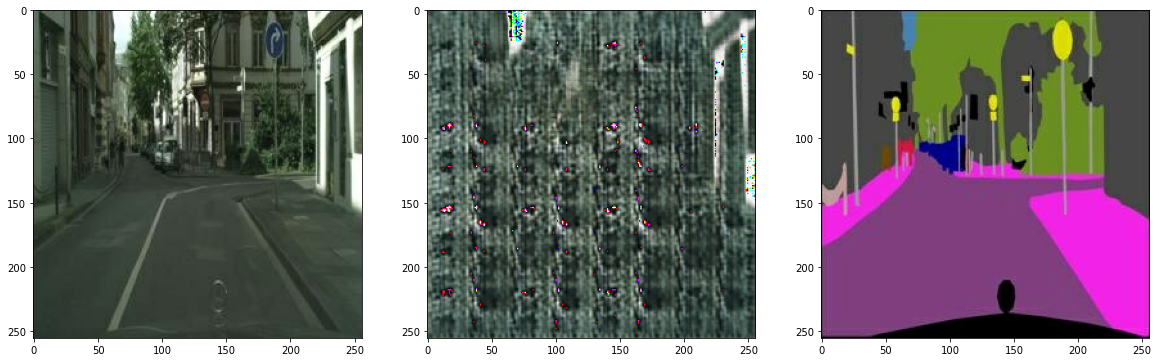

In [80]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

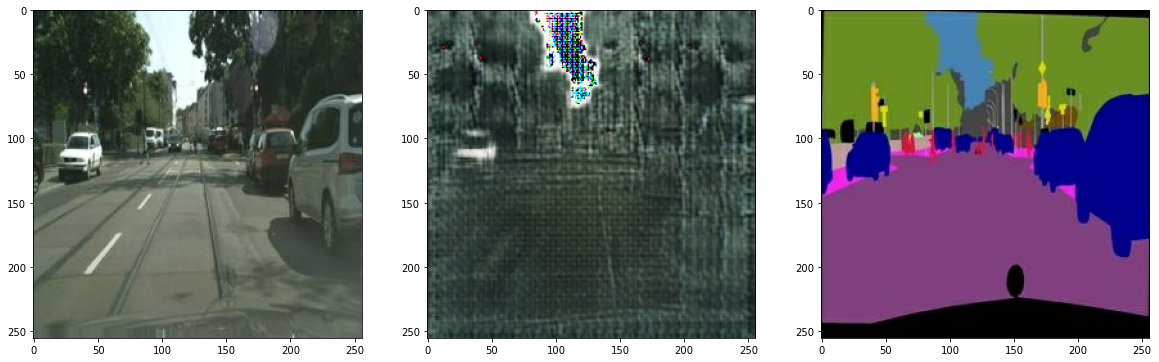

In [81]:
test_ind = 1

data_path1 = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'


f = data_path1 + os.listdir(data_path1)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 총평

## 루브릭

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.

데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.

U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.

3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.

10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

이번 노드는 시간이 오래 걸리는 노드였다.  
학습을 잘못 진행할 뻔 했지만 다른 분의 도움으로 return값의 sketch와 colored의 위치를 바꿔야 한다는 것을 알았다.  
return값의 위치를 바꾸는 이유(노드에서는 sketch를 보고 colored처럼 학습해야했지만 프로젝트에서는 colored를 sktech처럼 학습을 해야 했기 때문에)에 대해서도 알 수 있었다. 아마 안 알려줬다면 나는 이유를 몰랐을 텐데 그 분 덕분에 잘 해결했다.
학습은 15 epochs를 돌렸다. loss값이 내려갔다 올라갔다 하는데 loss값을 어떻게 해석해야할지 잘 모르겠다. 

15epcohs만 돌려서 그런지 제대로 된 결과물이 나오지는 않았다. 하지만 이전에 1epoch만 돌렸을 때랑 생각해서 비교해보면 1번 돌렸을 때는 아주 흐릿한 결과물만 나왔는데 그것에 비하면 15epochs는 더 많은 것들이 출력 됐다.